In [1]:
import nltk
#nltk.download('sentiwordnet')

from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# Basic Packages
import random
import pandas as pd

# Text Preprocessing Packages
import re
import nltk
# from nltk.tokenize import word_tokenize
import tweepy 
from tweepy.auth import OAuthHandler
from textblob import *

import warnings
warnings.filterwarnings("ignore")
def get_data(name):
    #name='gandhi'
    def initialize(): 

        # keys and tokens from the Twitter Dev Console 
        consumer_key = 'dmFvUSe8vymBDzFeRPQdZ73BD'
        consumer_secret = 'jJrqRbFVosOAaNqRsh8VAlaKpafYo6j7IeKxhzPDex0rHyB4AV'
        access_token = '1243538917216960513-0L371U4VJnyIFL04qubA1kdE4gkFI2'
        access_token_secret = 'g1SpNOoqfPM8uziOe5OrA2X2M1SnPolOiGZlcmY9uMOaz'

        # attempt authentication 
        try: 
            # create OAuthHandler object 
            auth = OAuthHandler(consumer_key, consumer_secret) 
            # set access token and secret 
            auth.set_access_token(access_token, access_token_secret) 
            # create tweepy API object to fetch tweets 
            api = tweepy.API(auth) 
            print('Authentication Success')
            return(api)

        except Exception as e: 
            print("Error: Authentication Failed")
            print(e)


    def get_tweets(api, query, count = 100): 
            # empty list to store parsed tweets 
            tweets = [] 
            sinceId = None
            max_id = -1
            tweetCount = 0
            tweetsPerQry = 100

            while tweetCount < count:
                try:
                    if (max_id <= 0):
                        if (not sinceId):
                            new_tweets = api.search(q=query, count=tweetsPerQry,lang='en')
                        else:
                            new_tweets = api.search(q=query, count=tweetsPerQry,
                                                    since_id=sinceId,lang='en')
                    else:
                        if (not sinceId):
                            new_tweets = api.search(q=query, count=tweetsPerQry,
                                                    max_id=str(max_id - 1),lang='en')
                        else:
                            new_tweets = api.search(q=query, count=tweetsPerQry,
                                                    max_id=str(max_id - 1),
                                                    since_id=sinceId,lang='en')
                    if not new_tweets:
                        print("No more tweets found")
                        break

                    for tweet in new_tweets:
                        parsed_tweet = {} 
                        parsed_tweet['tweets'] = tweet.text
                        parsed_tweet['date'] = tweet.created_at

                        # saving sentiment of tweet 
                        parsed_tweet['cleaned_tweets'],parsed_tweet['sentiment_score'],parsed_tweet['sentiment'] = get_sentiment(tweet.text)
                        #parsed_tweet['sentiments'] = [tag_sentiment(tweet.text)]
                        # appending parsed tweet to tweets list 
                        if tweet.retweet_count > 0: 
                            # if tweet has retweets, ensure that it is appended only once 
                            if parsed_tweet not in tweets: 
                                tweets.append(parsed_tweet) 
                        else: 
                            tweets.append(parsed_tweet) 

                    tweetCount += len(new_tweets)
                    #print("Downloaded {0} tweets".format(tweetCount))
                    max_id = new_tweets[-1].id
                   # print(max_id)
                   # print(new_tweets[-1])
                    return tweets
                except tweepy.TweepError as e:
                    print("Tweepy error : " + str(e))

    api_initialization = initialize()
    
    def clean_tweet(tweets): 
        ''' 
        Utility function to clean tweet text by removing links, special characters 
        using simple regex statements. 
        '''
        #print(tweets)
        return(' '.join(re.sub("([,\.():;!$%^&*\d])|([^0-9A-Za-z \t])", " ", tweets).split())) 

    def penn_to_wn(tag):
        if tag.startswith('J'):
            return wn.ADJ
        elif tag.startswith('N'):
            return wn.NOUN
        elif tag.startswith('R'):
            return wn.ADV
        elif tag.startswith('V'):
            return wn.VERB
        return None

    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()

    def get_sentiment(text):
        """ returns list of pos neg and objective score. But returns empty list if not present in senti wordnet. """
        cleaned_tweets = preprocess_tweet(text)
        tagged = nltk.pos_tag(word_tokenize(cleaned_tweets))
        sentiment_score = 0.0
        tokens_count = 0
        sentiment = []
        for word, tag in tagged:
            wn_tag = penn_to_wn(tag)
            if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
                continue

            lemma = lemmatizer.lemmatize(word, pos=wn_tag)
            if not lemma:
                continue

            synsets = wn.synsets(word, pos=wn_tag)
            if not synsets:
                continue

        # Take the first sense, the most common
            synset = synsets[0]
    #         print(synset)
    #         print(synset.name())
            swn_synset = swn.senti_synset(synset.name())
    #         print(swn_synset)
            sentiment_score += swn_synset.pos_score() - swn_synset.neg_score()
        
            tokens_count += 1
        if not tokens_count or sentiment_score == 0.13:
            sentiment.append('neutral')
 
    # sum greater than 0 => positive sentiment
        if sentiment_score > 0.13:
            sentiment.append('positive')
        elif sentiment_score < 0.13:
            sentiment.append('negative')
        # negative sentiment


        return cleaned_tweets,sentiment_score, sentiment.pop()

    contractions = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

    def expand_contractions(text):
        for word in text.split():
            if word.lower() in contractions:
                text = text.replace(word, contractions[word.lower()])
        return text

    def preprocess_word(word):
        # Remove punctuation
        word = word.strip('"?!,.():;')
        # Convert more than 2 letter repetitions to 2 letter
        # funnnnny --> funny
        word = re.sub(r'(.)\1+', r'\1\1', word)
        # Remove - & '
        word = re.sub(r'(-)', '', word)
        return word

    def is_valid_word(word):
        # Check if word begins with an alphabet
        return (re.search(r'^[a-zA-Z][a-z0-9A-Z\._]*$', word) is not None)

    def handle_emojis(tweet):
        # Smile -- :), : ), :-), (:, ( :, (-:, :')
        tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' EMO_POS ', tweet)
        # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
        tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' EMO_POS ', tweet)
        # Love -- <3, :*
        tweet = re.sub(r'(<3|:\*)', ' EMO_POS ', tweet)
        # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
        tweet = re.sub(r'(;-?\)|;-?D|\(-?;)', ' EMO_POS ', tweet)
        # Sad -- :-(, : (, :(, ):, )-:
        tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' EMO_NEG ', tweet)
        # Cry -- :,(, :'(, :"(
        tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' EMO_NEG ', tweet)
        return tweet
    from nltk import WordNetLemmatizer

    def preprocess_tweet(tweet):
        processed_tweet = []
        # Convert to lower case
        tweet = tweet.lower()
        tweet = expand_contractions(re.sub('’', "'", tweet))
        # Replaces URLs with the word URL
        tweet = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', ' URL ', tweet)
        # Replace @handle with the word USER_MENTION
        tweet = re.sub(r'@[\S]+', r' ', tweet)
        # Replaces #hashtag with hashtag
        tweet = re.sub(r'#(\S+)', r' \1 ', tweet)
        # Remove RT (retweet)
        tweet = re.sub(r'\brt\b', '', tweet)
        # Replace 2+ dots with space
        tweet = re.sub(r'\.{2,}', ' ', tweet)
        # Strip space, " and ' from tweet
        #tweet = tweet.strip(' "\'')
        # Replace emojis with either EMO_POS or EMO_NEG
        tweet = handle_emojis(tweet)
        # Replace multiple spaces with a single space
        tweet = re.sub(r'\s+', ' ', tweet)
        tweet = re.sub(r'(\[|\])',' ', tweet)
        
        words = tweet.split()

        for word in words:
            word = preprocess_word(word)
            if is_valid_word(word):
                #if use_stemmer:
                word = str(WordNetLemmatizer().lemmatize(word))
                processed_tweet.append(word)

        return ' '.join(processed_tweet)

    global retreived_tweets
    retreived_tweets = get_tweets(api=api_initialization,query=name, count = 100)

        
    return retreived_tweets

In [2]:
if __name__ == "__main__":
    get_data('OnePlus 8')
    pd.DataFrame(retreived_tweets)

Authentication Success


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from nltk.corpus import stopwords
from sklearn.metrics import classification_report,accuracy_score, recall_score, precision_score,f1_score
import collections
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

def train_tweets(df):
    df = pd.DataFrame(retreived_tweets)
    display(df.head())

    df = df[['tweets','sentiment']]

    df['sentiment']=df['sentiment'].astype("category")

    train_X, test_X, train_y, test_y = train_test_split(df['tweets'],df['sentiment'],test_size=0.3,random_state=523)

    #nltk.download('stopwords')

    stop_words = stopwords.words('english')

    Tfidf_vect = TfidfVectorizer(min_df=5,max_df=0.8,sublinear_tf=True,use_idf=True)
    Tfidf_vect.fit(train_X)
    train_X_Tfidf = Tfidf_vect.transform(train_X)
    test_X_Tfidf = Tfidf_vect.transform(test_X)

    acc_dict_train = {}
    acc_dict_test = {}

    # Classifier - Algorithm - SVM
    # fit the training dataset on the classifier
    SVM = svm.SVC(kernel='linear')
    SVM.fit(train_X_Tfidf,train_y)

    # predict the labels on train dataset
    pred_train1 = SVM.predict(train_X_Tfidf)

    # predict the labels on validation dataset
    pred_test1 = SVM.predict(test_X_Tfidf)

    # Use accuracy_score function to get the accuracy
    train_rmse1 = accuracy_score(train_y, pred_train1)*100
    test_rmse1 = accuracy_score(test_y, pred_test1)*100
    print("SVM Accuracy Score on Train set -> ", train_rmse1)
    print("SVM Accuracy Score on Validation set -> ", test_rmse1)

    acc_dict_test['SVM'] = accuracy_score(test_y, pred_test1)*100
    acc_dict_train['SVM'] = accuracy_score(train_y, pred_train1)*100


    print(classification_report(test_y,pred_test1))

    

    metric = collections.defaultdict(list)
    metric['SVM'].append(precision_score(train_y, pred_train1,average='macro'))
    metric['SVM'].append(recall_score(train_y, pred_train1,average='macro'))
    metric['SVM'].append(f1_score(train_y, pred_train1,average='macro'))

    # Classifier - Algorithm - Random Forest Algorithm

    #Import Random Forest Model
    
    Rforest = RandomForestClassifier(n_estimators=100)

    # fit the training dataset on the classifier
    Rforest.fit(train_X_Tfidf,train_y)

    # predict the labels on train dataset
    pred_train1 = Rforest.predict(train_X_Tfidf)

    # predict the labels on validation dataset
    pred_test1 = Rforest.predict(test_X_Tfidf)

    train_rmse2=accuracy_score(train_y, pred_train1)*100
    test_rmse2 =accuracy_score(test_y, pred_test1)*100


    # Use accuracy_score function to get the accuracy
    print("RandomForest Accuracy Score on Train set -> ",train_rmse2 )
    print("RandomForest Accuracy Score on Validation set -> ",test_rmse2)

    acc_dict_test['RF'] = accuracy_score(test_y, pred_test1)*100
    acc_dict_train['RF'] = accuracy_score(train_y, pred_train1)*100

    print(classification_report(test_y,pred_test1))

    metric['RF'].append(precision_score(train_y, pred_train1,average='macro'))
    metric['RF'].append(recall_score(train_y, pred_train1,average='macro'))
    metric['RF'].append(f1_score(train_y, pred_train1,average='macro'))

    # fit the training dataset on the NB classifier
    Naive = naive_bayes.MultinomialNB()
    Naive.fit(train_X_Tfidf,train_y)

    # predict the labels on train dataset
    pred_train = Naive.predict(train_X_Tfidf)

    # predict the labels on validation dataset
    pred_test = Naive.predict(test_X_Tfidf)

    train_rmse3=accuracy_score(train_y, pred_train)*100
    test_rmse3=accuracy_score(test_y, pred_test)*100



    # Use accuracy_score function to get the accuracy
    print("Naive Bayes Accuracy Score on Train set -> ", train_rmse3)
    print("Naive Bayes Accuracy Score on Validation set -> ",test_rmse3)

    acc_dict_test['NB'] = accuracy_score(test_y, pred_test)*100
    acc_dict_train['NB'] = accuracy_score(train_y, pred_train)*100

    print(classification_report(test_y,pred_test1))

    metric['NB'].append(precision_score(train_y, pred_train,average='macro'))
    metric['NB'].append(recall_score(train_y, pred_train,average='macro'))
    metric['NB'].append(f1_score(train_y, pred_train,average='macro'))

    # Logistic Regression Algorithm
    # fit the training dataset on the classifier
    

    clf = LogisticRegression(random_state=0).fit(train_X_Tfidf,train_y)

    clf.score(train_X_Tfidf,train_y)

    # predict the labels on train dataset
    pred_train1 = clf.predict(train_X_Tfidf)

    # predict the labels on validation dataset
    pred_test1 = clf.predict(test_X_Tfidf)

    train_rmse4=accuracy_score(train_y, pred_train1)*100
    test_rmse4=accuracy_score(test_y, pred_test1)*100

    # Use accuracy_score function to get the accuracy
    print("Logistic Regression Accuracy Score on Train set -> ",train_rmse4 )
    print("Logistic Regression Accuracy Score on Validation set -> ",test_rmse4)

    acc_dict_test['LG'] = accuracy_score(test_y, pred_test1)*100
    acc_dict_train['LG'] = accuracy_score(train_y, pred_train1)*100


    print(classification_report(test_y,pred_test1))

    metric['LG'].append(precision_score(train_y, pred_train1,average='macro'))
    metric['LG'].append(recall_score(train_y, pred_train1,average='macro'))
    metric['LG'].append(f1_score(train_y, pred_train1,average='macro'))

    # Classifier - Algorithm - Decision Tree
    # fit the training dataset on the classifier
    
    Dtree = DecisionTreeClassifier(random_state=0)
    Dtree.fit(train_X_Tfidf,train_y)

    # predict the labels on train dataset
    pred_train1 = Dtree.predict(train_X_Tfidf)

    # predict the labels on validation dataset
    pred_test1 = Dtree.predict(test_X_Tfidf)

    train_rmse5=accuracy_score(train_y, pred_train1)*100
    test_rmse5=accuracy_score(test_y, pred_test1)*100

    # Use accuracy_score function to get the accuracy
    print("Decision tree Accuracy Score on Train set -> ",train_rmse5 )
    print("Decision tree Accuracy Score on Validation set -> ",test_rmse5)

    acc_dict_test['DT'] = accuracy_score(test_y, pred_test1)*100
    acc_dict_train['DT'] = accuracy_score(train_y, pred_train1)*100

    print(classification_report(test_y,pred_test1))

    metric['DT'].append(precision_score(train_y, pred_train1,average='macro'))
    metric['DT'].append(recall_score(train_y, pred_train1,average='macro'))
    metric['DT'].append(f1_score(train_y, pred_train1,average='macro'))

    tmp = pd.DataFrame(dict(metric),index=['precision','recall','f1'])

    

    ax=tmp.plot(kind='bar',figsize=(16,6),width=0.8)
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy() 
        ax.annotate(f'{height*100:.3}%', (x + width/2, y + height*1.02), ha='center')
    plt.show()

    
    var1 =(mean_squared_error([train_rmse1],[test_rmse1]))
    var2 =(mean_squared_error([train_rmse2],[test_rmse2]))
    var3 =(mean_squared_error([train_rmse3],[test_rmse3]))
    var4 = (mean_squared_error([train_rmse4],[test_rmse4]))
    var5 = (mean_squared_error([train_rmse4],[test_rmse4]))
    var1=np.sqrt(var1)
    var2=np.sqrt(var2)
    var3=np.sqrt(var3)
    var4=np.sqrt(var4)
    var5=np.sqrt(var5)
    print("RMSE of SVM",var1)
    print("RMSE of Random Forest",var2)
    print("RMSE of Naive Bayes",var3)
    print("RMSE of Logistic Regression",var4)
    print("RMSE of Decision Tree",var4)

    x = np.arange(5)  # the label locations
    width = 0.35

    fig,ax = plt.subplots(figsize=(14,8))

    #ax = plt.subplot(121)

    br = ax.bar(x-width/2,list(acc_dict_train.values()),width, label='train')
    br2 = ax.bar(x+width/2,list(acc_dict_test.values()),width, label='test')
    ax.set_xticks((0,1,2,3,4))
    ax.set_xticklabels(['SVM','RF','NB','LG','DT'])
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy() 
        ax.annotate(f'{height:.4}%', (x + width/2, y + height*1.02), ha='center')
    ax.legend(loc='upper right')
    #fig.tight_layout()
    plt.show()

,tweets,date,cleaned_tweets,sentiment_score,sentiment
0,"OnePlus 8, 8 Pro gets Android Developer Previe...",2021-04-22 06:46:40,oneplus pro get android developer preview upda...,0.000,negative
1,"OnePlus 8, 8 Pro gets Android Developer Previe...",2021-04-22 06:45:54,oneplus pro get android developer preview upda...,0.000,negative
2,OnePlus Watch Midnight Black - https://t.co/3u...,2021-04-22 06:32:43,oneplus watch midnight black URL oneplus watch...,-0.375,negative
3,OnePlus Watch Midnight Black - https://t.co/3u...,2021-04-22 06:30:37,oneplus watch midnight black URL oneplus watch...,-0.375,negative
4,Still one of the top most flagship 5G smartpho...,2021-04-22 06:16:18,still one of the top most flagship smartphone ...,0.375,positive


SVM Accuracy Score on Train set ->  84.28571428571429
SVM Accuracy Score on Validation set ->  86.66666666666667
              precision    recall  f1-score   support

    negative       0.83      1.00      0.91        20
    positive       1.00      0.60      0.75        10

    accuracy                           0.87        30
   macro avg       0.92      0.80      0.83        30
weighted avg       0.89      0.87      0.86        30

RandomForest Accuracy Score on Train set ->  100.0
RandomForest Accuracy Score on Validation set ->  93.33333333333333
              precision    recall  f1-score   support

    negative       0.91      1.00      0.95        20
    positive       1.00      0.80      0.89        10

    accuracy                           0.93        30
   macro avg       0.95      0.90      0.92        30
weighted avg       0.94      0.93      0.93        30

Naive Bayes Accuracy Score on Train set ->  84.28571428571429
Naive Bayes Accuracy Score on Validation set ->  83.

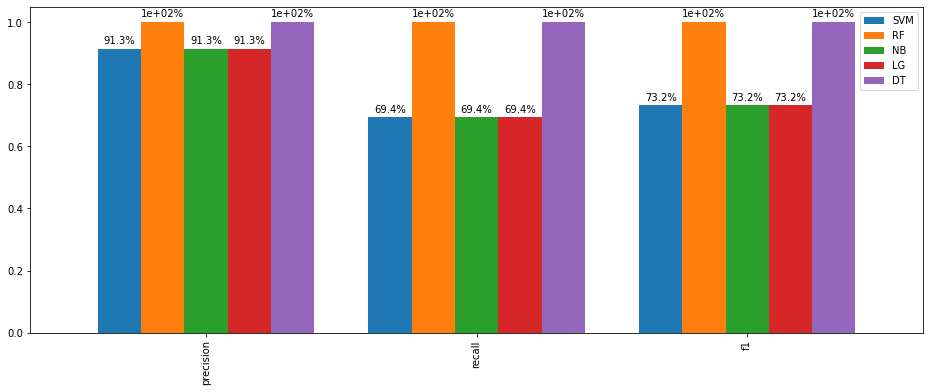

RMSE of SVM 2.3809523809523796
RMSE of Random Forest 6.666666666666671
RMSE of Naive Bayes 0.952380952380949
RMSE of Logistic Regression 4.285714285714292
RMSE of Decision Tree 4.285714285714292


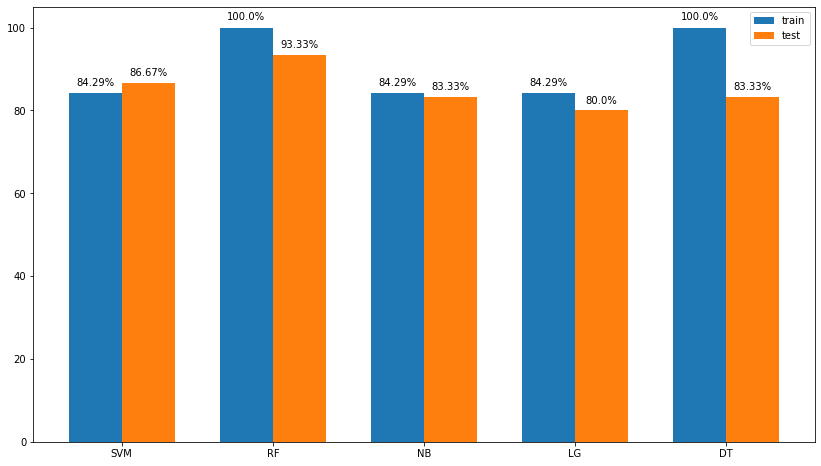

In [4]:
train_tweets(retreived_tweets)